# Legacy Halos - Paper I Figures

This notebook contains all the code used to generate the figures in Paper 1.

### Imports and plotting preferences

In [1]:
import os, warnings, pdb
import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib import ticker

In [2]:
import seaborn as sns
from astropy.io import fits
from astropy.table import Table

In [3]:
import legacyhalos.io
from legacyhalos.misc import lambda2mhalo, statsinbins, legacyhalos_plot_style

In [4]:
sns, colors = legacyhalos_plot_style(paper=True)
%matplotlib inline

### Specify which figures to (re)make

In [5]:
remake_radec = True

### Read the data set some paths

In [6]:
figdir = os.path.join(legacyhalos.io.legacyhalos_dir(), 'science', 'paper1', 'figures')

In [7]:
sample = legacyhalos.io.read_sample(verbose=True)
isedfit_lsphot = legacyhalos.io.read_sample(isedfit_lsphot=True, verbose=True)
isedfit_sdssphot = legacyhalos.io.read_sample(isedfit_sdssphot=True, verbose=True)

Read galaxy indices 0 through 229492 (N=229493) from /Users/ioannis/research/projects/legacyhalos/sample/legacyhalos-sample-dr6-dr7.fits
Read galaxy indices 0 through 229492 (N=229493) from /Users/ioannis/research/projects/legacyhalos/sample/isedfit-lsphot-dr6-dr7.fits


Print some statistics:

In [8]:
medz = np.median(sample['Z'])
medlam = 10**np.median(np.log10(sample['LAMBDA_CHISQ']))
print(medz, medlam, lambda2mhalo(medlam, redshift=0.4))

0.405044 11.0945788667 7.61649102803e+13


### Some useful functions

In [ ]:
def zbins():
    cosmo.lookback_time(0.2)

In [72]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
cosmo.age(0)

<Quantity 13.466983946956363 Gyr>

### Figure: Stellar mass function

In [35]:
mstar, merr, zobj = isedfit_lsphot['MSTAR_AVG'], isedfit_lsphot['MSTAR_ERR'], sample['Z']
np.sum(zobj < 0.1)

2021

0.15 0.284238 6428
0.24 0.287262 20195
0.33 0.281561 37114
0.42 0.29691 64146
0.51 0.29823 68467
0.6 0.333223 33143


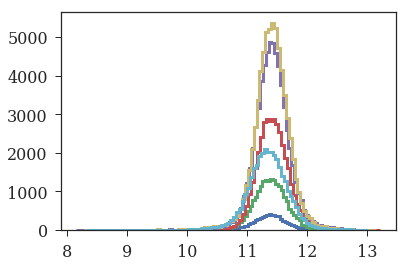

In [64]:
zmin, zmax, nzbin = 0.05+0.1, 0.6, 6
zbins = np.linspace(zmin, zmax, nzbin)
idz  = np.digitize(zobj, zbins)
for ii in range(nzbin):
    these = idz == ii
    plt.hist(mstar[these], bins=100, histtype='step', lw=3)
    print(zbins[ii], np.std(mstar[these]), np.sum(these))

In [ ]:
mederr = np.median(isedfit_lsphot['MSTAR_ERR'])
np.sqrt( np.std(isedfit_lsphot['MSTAR_AVG'])**2 - mederr**2 )

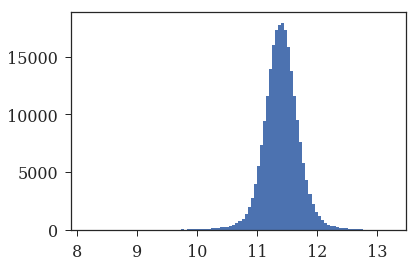

In [20]:
fig, ax = plt.subplots()
_ = ax.hist(isedfit_lsphot['MSTAR_AVG'], bins=100)

In [9]:
stop

NameError: name 'stop' is not defined

### Figure: Richness vs redshift

In [31]:
def fig_lambda_redshift(png=None):

    cmap = 'viridis' # 'RdYlBu'
    xmin, xmax = 0.05, 0.6
    ymin, ymax = np.log10(5), 2.1
    
    j = sns.jointplot(sample['Z'], np.log10(sample['LAMBDA_CHISQ']), kind='hex', #space=0, 
                      stat_func=None, cmap=cmap, mincnt=3, bins='log', gridsize=150,
                      xlim=(xmin, xmax), ylim=(ymin, ymax),
                      marginal_kws={'hist_kws': {'color': 'black'}})
    j.set_axis_labels('Redshift', r'$\log_{10}$ (Richness $\lambda$)')
    #j.ax_joint.axvline(x=0.05, color='k', lw=2, alpha=0.5)
    #j.ax_joint.axvline(x=0.6, color='k', lw=2, alpha=0.5)
    j.ax_joint.margins(0)

    j.fig.set_figwidth(10)
    j.fig.set_figheight(6)
    
    #ax.axhline(y=np.log10(5), ls='--', color='k')

    cax = j.fig.add_axes([0.18, -0.08, 0.65, 0.05])
    cb = plt.colorbar(orientation='horizontal', cax=cax)
    cb.set_label(r'$\log_{10}$ (Number of Centrals)')       

    ax2 = j.ax_marg_y.twinx()
    ax2.set_ylabel(r'$\log_{10}\, (\mathcal{M}_{200}\, /\, \mathcal{M}_{\odot})$ at $z=0.4$')
    ax2.set_ylim( np.log10(lambda2mhalo(10**ymin, redshift=0.4)), 
                  np.log10(lambda2mhalo(10**ymax, redshift=0.4)) )
    #ax2.plot([],[])
    sns.despine(ax=ax2, left=True, right=False)
    ax2.spines['bottom'].set_color('white')
    
    if png:
        pngfile = os.path.join(figdir, png)
        print('Writing {}'.format(pngfile))
        j.fig.savefig(pngfile, bbox_inches='tight', pad_inches=0)

/usr/local/anaconda3/envs/legacyhalos/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Writing /Users/ioannis/research/projects/legacyhalos/science/paper1/figures/lambda_redshift.png


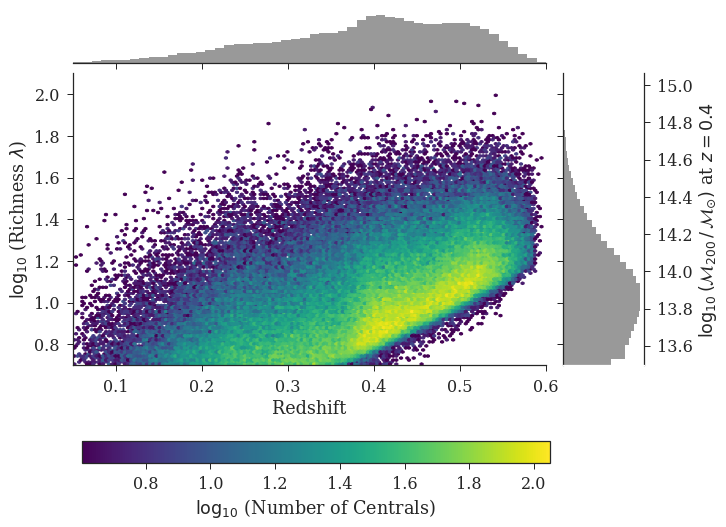

In [32]:
fig_lambda_redshift(png='lambda_redshift.png')

### Figure: Central galaxy montage

Add code here!

### Figure: RA, Dec of parent sample

ToDo:
* Limit the declination to ~-20 deg or so;
* Add the DESI and/or SDSS footprint;
* Correct for partial pixels.

In [ ]:
def fig_radec(png=None):
    from legacyhalos.desiutil import init_sky, plot_sky_binned
    fig, ax = plt.subplots(figsize=(8, 8))

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        basemap = init_sky(galactic_plane_color='k', ax=ax)
        _, grid_data = plot_sky_binned(sample['RA'], sample['DEC'], #weights=data['WEIGHT'],
                                       max_bin_area=1.0, verbose=True, clip_lo='!1', cmap='viridis',
                                       plot_type='healpix', basemap=basemap,
                                       label=r'$N$(Central Galaxies) (deg$^{-2}$)',
                                       return_grid_data=True)
    print('Median density = {:.3f}/deg2'.format(ma.median(grid_data)))

    if png:
        pngfile = os.path.join(figdir, png)
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile, bbox_inches='tight', pad_inches=0)

In [ ]:
fig_radec(png='radec.png')

In [ ]:
stop

### Richness-redshift and halo mass-redshift relations.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

hb = ax.hexbin(rm['Z'], np.log10(rm['LAMBDA_CHISQ']), mincnt=3,
               cmap=plt.cm.get_cmap('RdYlBu'), alpha=0.5, bins='log')
ax.set_xlabel('Redshift $z$')
ax.set_ylabel(r'$\log_{10}$ (Richness $\lambda$)')
ax.set_xlim(0, 0.6)
ymin, ymax = np.log10(3), 2.3
ax.set_ylim(ymin, ymax)
ax.axhline(y=np.log10(5), ls='--', color='k')

cax = fig.add_axes([0.1, 1.05, 0.8, 0.05])
cb = plt.colorbar(hb, orientation='horizontal', cax=cax)
cb.set_label(r'$\log_{10}$ (Number of Galaxies)')       

ax2 = ax.twinx()
ax2.set_ylabel(r'$\log_{10}\, (M_{200}\, /\, M_{\odot})$ at $z=0.3$')
ax2.set_ylim( np.log10(lambda2mhalo(ymin)), np.log10(lambda2mhalo(ymax)) )
ax2.plot([],[])

### Compare LS/SDSS magnitudes and colors.

In [ ]:
def unextinct_sdssphot(phot):
    """Correct SDSS photometry for MW extinction and compute colors."""
    dtype = [('g', 'f4'), ('r', 'f4'), ('z', 'f4'), 
             ('W1', 'f4'), ('W2', 'f4'), 
             ('gr', 'f4'), ('rz', 'f4')]
    result = np.zeros(len(phot), dtype=dtype)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        ugriz = 22.5 - 2.5 * np.log10(phot['CMODELMAGGIES']) - phot['EXTINCTION']
    
        result['g'] = ugriz[:, 1]
        result['r'] = ugriz[:, 2]
        result['z'] = ugriz[:, 4]
        result['gr'] = result['g'] - result['r']
        result['rz'] = result['r'] - result['z']
        
    return Table(result)

In [ ]:
def unextinct_lsphot(phot):
    """Correct LS photometry for MW extinction and compute colors."""
    dtype = [('g', 'f4'), ('r', 'f4'), ('z', 'f4'), 
             ('W1', 'f4'), ('W2', 'f4'), 
             ('gr', 'f4'), ('rz', 'f4')]
    result = np.zeros(len(phot), dtype=dtype)

    g = phot['FLUX_G'] / phot['MW_TRANSMISSION_G']
    r = phot['FLUX_R'] / phot['MW_TRANSMISSION_R']
    z = phot['FLUX_Z'] / phot['MW_TRANSMISSION_Z']
    W1 = phot['FLUX_W1'] / phot['MW_TRANSMISSION_W1']
    W2 = phot['FLUX_W2'] / phot['MW_TRANSMISSION_W2']
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        result['g'] = 22.5 - 2.5 * np.log10(g)
        result['r'] = 22.5 - 2.5 * np.log10(r)
        result['z'] = 22.5 - 2.5 * np.log10(z)
        result['W1'] = 22.5 - 2.5 * np.log10(W1)
        result['W2'] = 22.5 - 2.5 * np.log10(W2)
        result['gr'] = result['g'] - result['r']
        result['rz'] = result['r'] - result['z']
        
    return Table(result)

In [ ]:
ls = unextinct_lsphot(lsphot)

In [ ]:
sdss = unextinct_sdssphot(sdssphot)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
for ii, band in enumerate(('g', 'r', 'z')):
    hb = ax[ii].hexbin(ls[band], sdss[band], mincnt=1,
                cmap=plt.cm.Blues_r, alpha=0.5, bins='log')
    ax[ii].set_xlim(13, 25)
    ax[ii].set_ylim(13, 25)
    #ax[ii].legend(loc='upper left')
    ax[ii].plot([10, 30], [10, 30], color='k', ls='--')
    ax[ii].set_xlabel('mag (SDSS)')
ax[0].set_ylabel('mag (LS)')
cb = plt.colorbar(hb)
cb.set_label(r'$\log_{10}$ (Number of Galaxies)')
fig.subplots_adjust(wspace=0.05)

### Compare LS/UPenn magnitudes and colors.

In [ ]:
lsupenn = Table(fits.getdata(parentupennfile, extname='LSPHOT'))

In [ ]:
sdssupenn = Table(fits.getdata(parentupennfile, extname='SDSSPHOT'))

In [ ]:
upenn = Table(fits.getdata(parentupennfile, extname='UPENN'))
upenn.colnames

In [ ]:
lsupennphot = unextinct_lsphot(lsupenn)
sdssupennphot = unextinct_sdssphot(sdssupenn)

In [ ]:
minmag, maxmag = 14, 20
fig, ax = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
for ii, band in enumerate(('g', 'r')):
    hb = ax[ii].hexbin(upenn['{}_M_TOT'.format(band.upper())], sdssupennphot[band], 
                       mincnt=1, cmap=plt.cm.Blues_r, alpha=0.5, #bins='log',
                       extent=(minmag, maxmag, minmag, maxmag),
                       vmin=0, vmax=15)
    ax[ii].set_xlim(minmag, maxmag)
    ax[ii].set_ylim(minmag, maxmag)
    ax[ii].plot([10, 30], [10, 30], color='k', ls='--')
    ax[ii].set_xlabel('mag (UPenn-PhotDec)')
cax = fig.add_axes([0.92, 0.15, 0.02, 0.72])
cb = plt.colorbar(hb, cax=cax)
cb.set_label('Number of Galaxies per Bin') 
ax[0].set_ylabel('mag (SDSS)')
fig.subplots_adjust(wspace=0.05)

In [ ]:
minmag, maxmag = 14, 20
fig, ax = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
for ii, band in enumerate(('g', 'r')):
    hb = ax[ii].hexbin(upenn['{}_M_TOT'.format(band.upper())], lsupennphot[band], 
                       mincnt=1, cmap=plt.cm.Blues_r, alpha=0.5, #bins='log',
                       extent=(minmag, maxmag, minmag, maxmag),
                       vmin=0, vmax=15)
    ax[ii].set_xlim(minmag, maxmag)
    ax[ii].set_ylim(minmag, maxmag)
    ax[ii].plot([10, 30], [10, 30], color='k', ls='--')
    ax[ii].set_xlabel('mag (UPenn-PhotDec)')
cax = fig.add_axes([0.92, 0.15, 0.02, 0.72])
cb = plt.colorbar(hb, cax=cax)
cb.set_label('Number of Galaxies per Bin')
#cb.set_label(r'$\log_{10}$ (Number of Galaxies)')    
ax[0].set_ylabel('mag (LS)')
fig.subplots_adjust(wspace=0.05)